# Set-up

In [1]:
import os
import sys
import torch
import numpy as np
import seqdata as sd
from eugene import models
from eugene.models import zoo
import seqexplainer as se
from eugene import plot as pl
import matplotlib.pyplot as plt
from seqexplainer.attributions._plot import plot_attribution_logo, plot_attribution_logo_heatmap

sys.path.append("/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/bin")
from plot import scatter

In [2]:
# Change current working directory to the directory of this script
cwd = "/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind"
os.chdir(cwd)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Load test dataset

In [4]:
# Load the dataset
sdata = sd.open_zarr("/cellar/users/aklie/data/ml4gland/pubs/koo21_gia/log_norm/rnacompete2013_test.zarr")
sdata.load()

<xarray.Dataset>
Dimensions:    (_sequence: 121031, _length: 41, _ohe: 4, _target: 244)
Dimensions without coordinates: _sequence, _length, _ohe, _target
Data variables:
    inputs     (_sequence, _length, _ohe) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rbp_id     (_target) <U11 'RNCMPT00100' 'RNCMPT00101' ... 'RNCMPT00009'
    rbp_index  (_target) int64 0 1 2 3 4 5 6 7 ... 237 238 239 240 241 242 243
    targets    (_sequence, _target) float32 0.795 -0.2654 -0.2193 ... 0.6552 nan

# Load best model

In [5]:
# Instantiate an architecture
arch = zoo.ResidualBind(
    input_len=41,
    output_dim=1
)

In [6]:
module = models.SequenceModule.load_from_checkpoint(
    "models/2023_12_16/ResidualBind/log_norm/RNCMPT00100/best_model.ckpt",
    arch=arch,
)

[rank: 0] Global seed set to 1234


# Get predictions

In [7]:
module.to(device).eval();

In [8]:
preds = module.predict(
    sdata["inputs"].values.transpose(0, 2, 1),
    batch_size=128
).cpu().numpy().squeeze()

Predicting on batches:   0%|          | 0/945 [00:00<?, ?it/s]

In [9]:
sdata["target"] = sdata["targets"][:, 0]
obs = sdata["target"].values

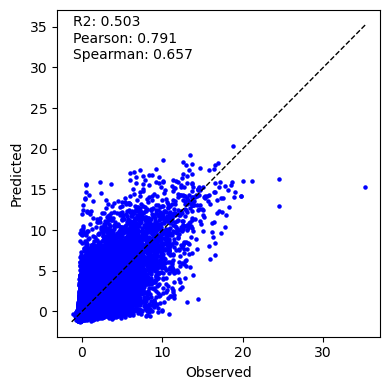

In [10]:
scatter(
    preds,
    obs,
    density=False,
    rasterized=True,
    s=5,
)

# In silico mutagenesis

In [11]:
inputs = sdata["inputs"][:128].values.transpose(0, 2, 1)

In [80]:
from seqexplainer.attributions import gradient_correction
from bpnetlite.attributions import hypothetical_attributions

In [86]:
attrs = se.attribute(module, inputs, method="NaiveISM", hypothetical=True, attribution_func=None)

Computing attributions on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

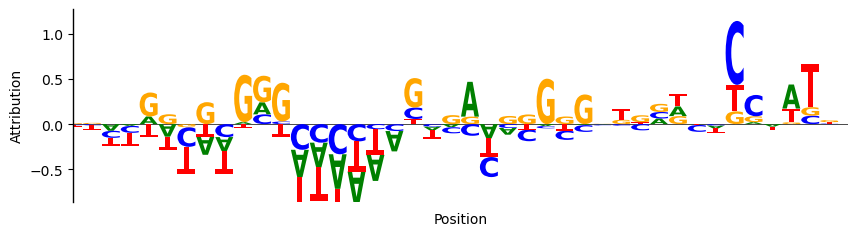

In [98]:
plot_attribution_logo(attrs[3])

In [96]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


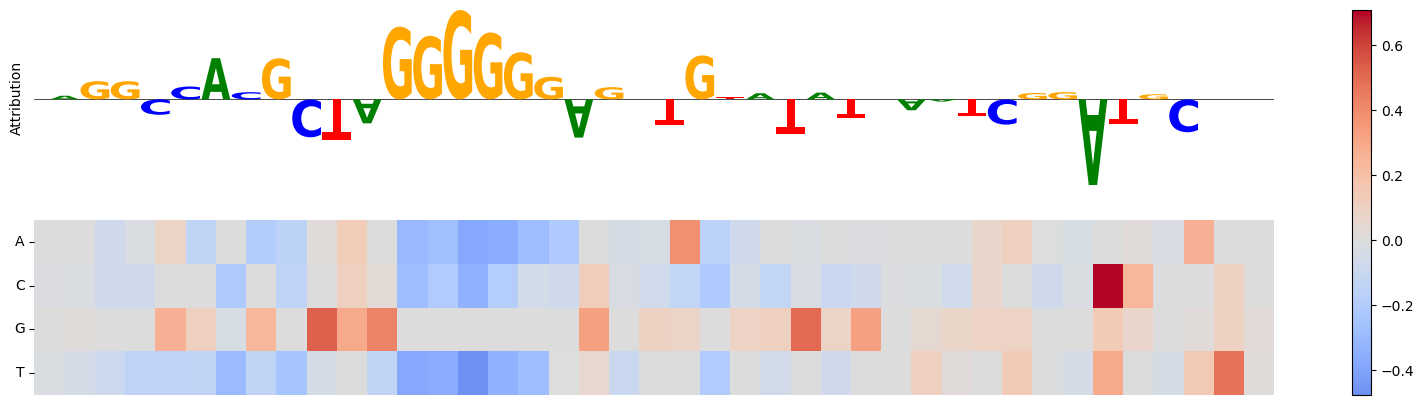

In [100]:
plot_attribution_logo_heatmap(attrs[3], inputs=inputs[3], flip_sign=True, figsize=(20, 5))

In [244]:
index = [29849, 105952]
X = sdata['inputs'].values[index]

In [77]:
def generate_mutagenesis(X):
        L,A = X.shape 
        X_mut = []
        for l in range(L):
            for a in range(A):
                X_new = np.copy(X)
                X_new[l,:] = 0
                X_new[l,a] = 1
                X_mut.append(X_new)
        return np.array(X_mut)

def mutagenesis(model, X):
    N, L, A = X.shape 

    attr_score = []
    for x in X:

        # get baseline wildtype score
        wt_score = model.predict(np.expand_dims(x, axis=0)).numpy().squeeze()

        # generate mutagenized sequences
        x = x.transpose(1, 0)
        x_mut = generate_mutagenesis(x)
        
        # get predictions of mutagenized sequences
        predictions = model.predict(x_mut.transpose(0,2,1)).numpy().squeeze()
        
        # reshape mutagenesis predictiosn
        mut_score = np.zeros((L,A))
        k = 0
        for l in range(L):
            for a in range(A):
                mut_score[l,a] = predictions[k]
                k += 1
                
        attr_score.append(mut_score - wt_score)
    return np.array(attr_score)

In [86]:
attr_map = mutagenesis(module, X.transpose(0, 2, 1))
scores = (np.sum(attr_map**2, axis=2, keepdims=True)*X.transpose(0, 2, 1)).transpose(0, 2, 1)

Predicting on batches: 0it [00:00, ?it/s]

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting on batches: 0it [00:00, ?it/s]

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
import pandas as pd
import logomaker as lmddd

In [88]:
scores.shape

(2, 41, 4)

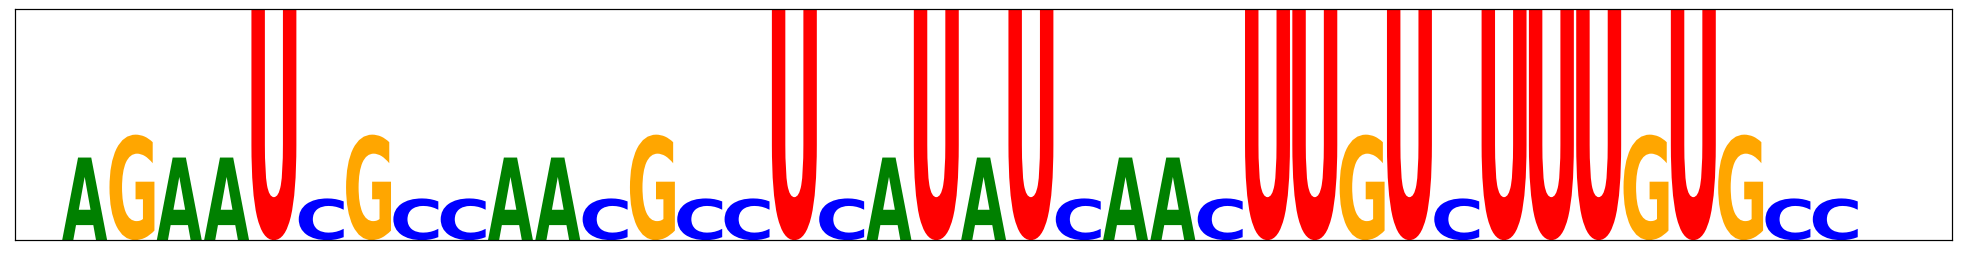

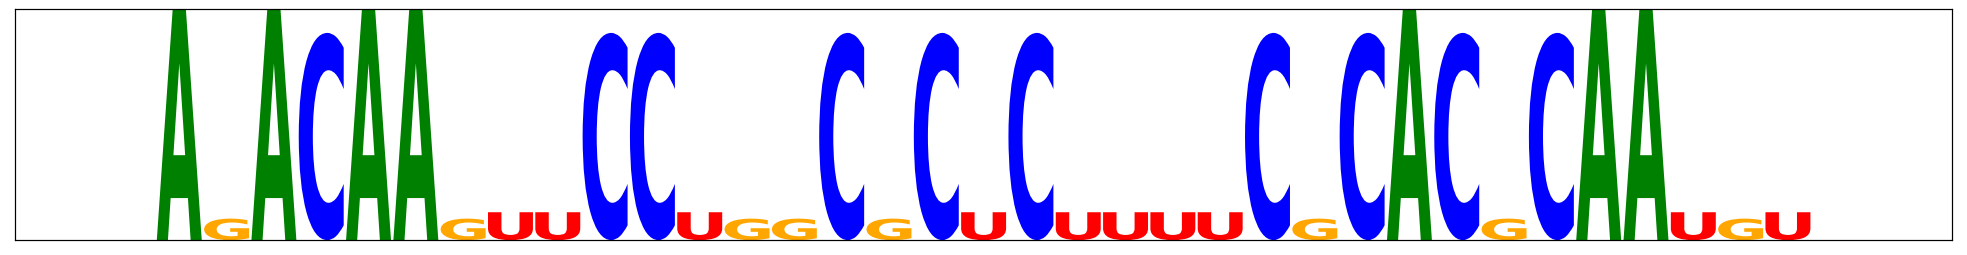

In [89]:
N, L, A = X.shape
for k in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = scores[k,l,a]

    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(1,1,1)
    lm.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    plt.yticks([])
    